#ANLY 590 Final Project  
##Blood Cells Classification  
###Jiaqi Hu, Fan Liang, Tuo Wu

In [0]:
import numpy as np
import tensorflow as tf
import pandas as pd
import cv2
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
import random
from tensorflow.keras.layers import Dense, Conv2D, BatchNormalization, Dropout, MaxPool2D, Input, Softmax, Activation, Flatten
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras import optimizers
from tensorflow.keras.layers import concatenate,AveragePooling2D
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import plot_model
from tensorflow.keras import layers,models
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping

In [8]:
# colab path
# load driver for google colab
# under github version, the next several lines could be ignored
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
# colab file path
train_path = '/content/drive/Shared drives/590 project/blood_cell/blood-cells/dataset2-master/dataset2-master/images/TRAIN/'
test_path = '/content/drive/Shared drives/590 project/blood_cell/blood-cells/dataset2-master/dataset2-master/images/TEST/'

In [0]:
# train_path = '/Users/fan/Dropbox/blood_cell/blood-cells/dataset2-master/dataset2-master/images/TRAIN/'
# test_path = '/Users/fan/Dropbox/blood_cell/blood-cells/dataset2-master/dataset2-master/images/TEST/'

In [0]:
def get_data(folder):
    #    Load the data and labels from the given folder.
    X = []
    y = []
    for wbc_type in os.listdir(folder):
        #print(wbc_type)
        if not wbc_type.startswith('.'):
            if wbc_type in ['NEUTROPHIL']:
                label = 1
            elif wbc_type in ['EOSINOPHIL']:
                label = 2
            elif wbc_type in ['MONOCYTE']:
                label = 3  
            elif wbc_type in ['LYMPHOCYTE']:
                label = 4 
            else:
                label = 5
            for image_filename in tqdm(os.listdir(folder + wbc_type)):
                img_file = cv2.imread(folder + wbc_type + '/' + image_filename)
                if img_file is not None:
                    img_file = cv2.resize(img_file, dsize=(80,60), interpolation=cv2.INTER_CUBIC)
                    img_arr = np.asarray(img_file)
                    X.append(img_arr)
                    y.append(label)
                    
    X = np.asarray(X)
    y = np.asarray(y)
    return X,y

In [6]:
train_x,train_y = get_data(train_path)
test_x,test_y = get_data(test_path)

100%|██████████| 624/624 [05:18<00:00,  2.51it/s]


In [0]:
neu,eos,mon,lym = [],[],[],[]

In [12]:
import pandas as pd
pd.value_counts(train_y)

1    2499
2    2497
4    2483
3    2482
dtype: int64

In [0]:
for file in random.choices(os.listdir(train_path + 'NEUTROPHIL'),k = 4):
    img_file = cv2.imread(train_path + 'NEUTROPHIL/' + file)
    neu.append(img_file)
neu = np.asarray(neu)

In [0]:
for file in random.choices(os.listdir(train_path + 'EOSINOPHIL'),k = 4):
    img_file = cv2.imread(train_path + 'EOSINOPHIL/' + file)
    eos.append(img_file)
eos = np.asarray(eos)

In [0]:
for file in random.choices(os.listdir(train_path + 'MONOCYTE'),k = 4):
    img_file = cv2.imread(train_path + 'MONOCYTE/' + file)
    mon.append(img_file)
mon = np.asarray(mon)

In [0]:
for file in random.choices(os.listdir(train_path + 'LYMPHOCYTE'),k = 4):
    img_file = cv2.imread(train_path + 'LYMPHOCYTE/' + file)
    lym.append(img_file)
lym = np.asarray(lym)

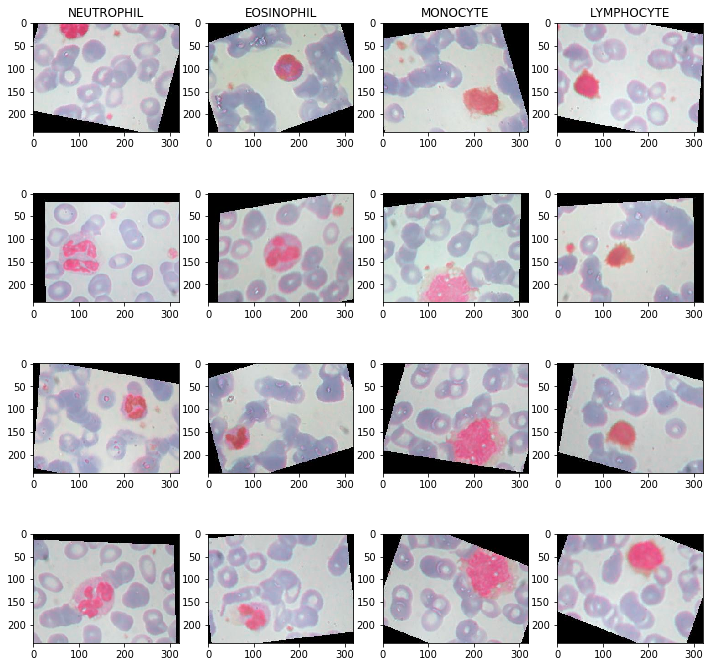

In [17]:
plt.figure(figsize = (12,12))
plt.subplot(4,4,1)
plt.imshow(neu[0])
plt.title('NEUTROPHIL')
plt.subplot(4,4,5)
plt.imshow(neu[1])
plt.subplot(4,4,9)
plt.imshow(neu[2])
plt.subplot(4,4,13)
plt.imshow(neu[3])

plt.subplot(4,4,2)
plt.imshow(eos[0])
plt.title('EOSINOPHIL')
plt.subplot(4,4,6)
plt.imshow(eos[1])
plt.subplot(4,4,10)
plt.imshow(eos[2])
plt.subplot(4,4,14)
plt.imshow(eos[3])

plt.subplot(4,4,3)
plt.imshow(mon[0])
plt.title('MONOCYTE')
plt.subplot(4,4,7)
plt.imshow(mon[1])
plt.subplot(4,4,11)
plt.imshow(mon[2])
plt.subplot(4,4,15)
plt.imshow(mon[3])

plt.subplot(4,4,4)
plt.imshow(lym[0])
plt.title('LYMPHOCYTE')
plt.subplot(4,4,8)
plt.imshow(lym[1])
plt.subplot(4,4,12)
plt.imshow(lym[2])
plt.subplot(4,4,16)
plt.imshow(lym[3])

#plt.savefig('/Users/fan/Dropbox/blood_cell/basicplot.png')

In [18]:
from keras.utils.np_utils import to_categorical
trainHot_y = to_categorical(train_y, num_classes = 5)
testHot_y = to_categorical(test_y, num_classes = 5)
dict_characters = {1:'NEUTROPHIL',2:'EOSINOPHIL',3:'MONOCYTE',4:'LYMPHOCYTE'}

Using TensorFlow backend.


## Basic Model

In [0]:
model = models.Sequential()
model.add(layers.BatchNormalization(input_shape = (60,80,3)))
model.add(layers.Conv2D(32, (5,5), padding = 'same',strides = (2,2),activation='relu'))
model.add(layers.MaxPool2D((3, 3),padding = 'same',strides = (2,2)))
model.add(layers.Conv2D(16,(3, 3), padding = 'same',strides = (1,1)))
model.add(layers.MaxPool2D((3, 3),padding = 'same',strides = (2,2)))
model.add(layers.Conv2D(16,(1, 1), padding = 'same',strides = (1,1)))
model.add(layers.MaxPool2D((2, 2),padding = 'same',strides = (1,1)))

#model.add(layers.Dropout(0.1))
model.add(layers.Flatten())
#model.add(layers.Dense(16, activation='relu',kernel_regularizer=regularizers.l2(0.1)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(5, activation='softmax'))

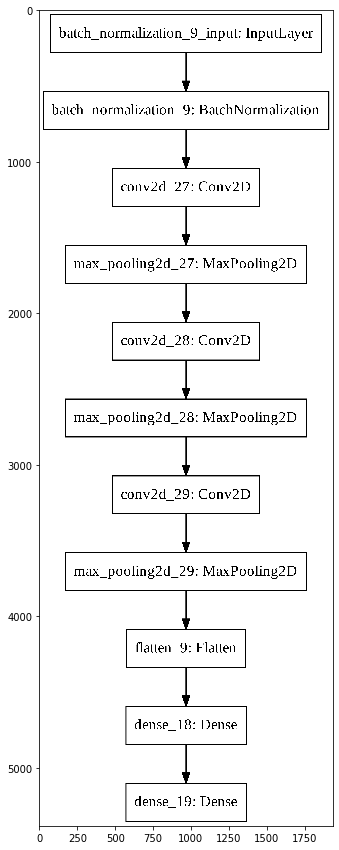

In [135]:
plot_model(model,to_file='model_plot.png',show_layer_names=True,dpi=500)
plt.figure(figsize=(10,15))
plt.imshow(plt.imread('model_plot.png'))

In [0]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'], 
              #callbacks = [EarlyStopping(monitor='val_acc', patience=5)]
              )

In [137]:
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_9 (Batch (None, 60, 80, 3)         12        
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 30, 40, 32)        2432      
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 15, 20, 32)        0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 15, 20, 16)        4624      
_________________________________________________________________
max_pooling2d_28 (MaxPooling (None, 8, 10, 16)         0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 8, 10, 16)         272       
_________________________________________________________________
max_pooling2d_29 (MaxPooling (None, 8, 10, 16)        

In [138]:
history = model.fit(train_x, trainHot_y, epochs = 100, batch_size = 8, validation_data=(test_x, testHot_y), shuffle=True)

Train on 9961 samples, validate on 2487 samples
Epoch 1/100
9961/9961 [==============================] - 8s 762us/sample - loss: 1.2542 - acc: 0.4087 - val_loss: 0.8731 - val_acc: 0.6265
Epoch 2/100
9961/9961 [==============================] - 7s 752us/sample - loss: 0.6410 - acc: 0.7431 - val_loss: 0.7576 - val_acc: 0.6932
Epoch 3/100
9961/9961 [==============================] - 7s 719us/sample - loss: 0.3857 - acc: 0.8411 - val_loss: 0.8286 - val_acc: 0.7069
Epoch 4/100
9961/9961 [==============================] - 7s 720us/sample - loss: 0.3046 - acc: 0.8735 - val_loss: 0.5734 - val_acc: 0.7825
Epoch 5/100
9961/9961 [==============================] - 7s 721us/sample - loss: 0.2573 - acc: 0.8908 - val_loss: 0.6267 - val_acc: 0.7857
Epoch 6/100
9961/9961 [==============================] - 7s 723us/sample - loss: 0.2269 - acc: 0.9064 - val_loss: 0.8053 - val_acc: 0.7744
Epoch 7/100
9961/9961 [==============================] - 7s 733us/sample - loss: 0.2026 - acc: 0.9168 - val_loss: 0.81

model 1 dropout 0.1

In [0]:
model1 = models.Sequential()
model1.add(layers.BatchNormalization(input_shape = (60,80,3)))
model1.add(layers.Conv2D(32, (5,5), padding = 'same',strides = (2,2),activation='relu'))
model1.add(layers.MaxPool2D((3, 3),padding = 'same',strides = (2,2)))
model1.add(layers.Conv2D(16,(3, 3), padding = 'same',strides = (1,1)))
model1.add(layers.MaxPool2D((3, 3),padding = 'same',strides = (2,2)))
model1.add(layers.Conv2D(16,(1, 1), padding = 'same',strides = (1,1)))
model1.add(layers.MaxPool2D((2, 2),padding = 'same',strides = (1,1)))
model1.add(layers.Dropout(0.1))
model1.add(layers.Flatten())
#model.add(layers.Dense(16, activation='relu',kernel_regularizer=regularizers.l2(0.1)))
model1.add(layers.Dense(16, activation='relu'))
model1.add(layers.Dense(5, activation='softmax'))

In [0]:
model1.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy']
              #callbacks = [EarlyStopping(monitor='val_acc', patience=5)]
              )

In [141]:
history1 = model1.fit(train_x, trainHot_y, epochs = 100, batch_size = 8, validation_data=(test_x, testHot_y), shuffle=True)

Train on 9961 samples, validate on 2487 samples
Epoch 1/100
9961/9961 [==============================] - 8s 805us/sample - loss: 1.3750 - acc: 0.2923 - val_loss: 1.3785 - val_acc: 0.2770
Epoch 2/100
9961/9961 [==============================] - 8s 757us/sample - loss: 1.1758 - acc: 0.4615 - val_loss: 0.9239 - val_acc: 0.5621
Epoch 3/100
9961/9961 [==============================] - 8s 755us/sample - loss: 0.7305 - acc: 0.7016 - val_loss: 0.8841 - val_acc: 0.6257
Epoch 4/100
9961/9961 [==============================] - 8s 771us/sample - loss: 0.4148 - acc: 0.8354 - val_loss: 0.5965 - val_acc: 0.7640
Epoch 5/100
9961/9961 [==============================] - 7s 737us/sample - loss: 0.2895 - acc: 0.8817 - val_loss: 0.7071 - val_acc: 0.7672
Epoch 6/100
9961/9961 [==============================] - 7s 745us/sample - loss: 0.2549 - acc: 0.8971 - val_loss: 0.8170 - val_acc: 0.7551
Epoch 7/100
9961/9961 [==============================] - 7s 738us/sample - loss: 0.1912 - acc: 0.9226 - val_loss: 0.90

model 2 dropout 0.3

In [0]:
model2 = models.Sequential()
model2.add(layers.BatchNormalization(input_shape = (60,80,3)))
model2.add(layers.Conv2D(32, (5,5), padding = 'same',strides = (2,2),activation='relu'))
model2.add(layers.MaxPool2D((3, 3),padding = 'same',strides = (2,2)))
model2.add(layers.Conv2D(16,(3, 3), padding = 'same',strides = (1,1)))
model2.add(layers.MaxPool2D((3, 3),padding = 'same',strides = (2,2)))
model2.add(layers.Conv2D(16,(1, 1), padding = 'same',strides = (1,1)))
model2.add(layers.MaxPool2D((2, 2),padding = 'same',strides = (1,1)))
model2.add(layers.Dropout(0.3))
model2.add(layers.Flatten())
#model.add(layers.Dense(16, activation='relu',kernel_regularizer=regularizers.l2(0.1)))
model2.add(layers.Dense(16, activation='relu'))
model2.add(layers.Dense(5, activation='softmax'))

In [0]:
model2.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy']
              #callbacks = [EarlyStopping(monitor='val_acc', patience=5)]
              )

In [181]:
history2 = model2.fit(train_x, trainHot_y, epochs = 100, validation_data=(test_x, testHot_y), shuffle=True)

Train on 9961 samples, validate on 2487 samples
Epoch 1/100
9961/9961 [==============================] - 3s 312us/sample - loss: 1.3366 - acc: 0.3337 - val_loss: 1.1600 - val_acc: 0.4560
Epoch 2/100
9961/9961 [==============================] - 2s 237us/sample - loss: 1.0236 - acc: 0.5338 - val_loss: 0.7613 - val_acc: 0.6695
Epoch 3/100
9961/9961 [==============================] - 2s 241us/sample - loss: 0.6085 - acc: 0.7620 - val_loss: 0.7081 - val_acc: 0.6791
Epoch 4/100
9961/9961 [==============================] - 2s 242us/sample - loss: 0.4789 - acc: 0.8130 - val_loss: 0.5427 - val_acc: 0.7644
Epoch 5/100
9961/9961 [==============================] - 2s 233us/sample - loss: 0.4109 - acc: 0.8361 - val_loss: 0.4766 - val_acc: 0.7933
Epoch 6/100
9961/9961 [==============================] - 2s 237us/sample - loss: 0.3405 - acc: 0.8585 - val_loss: 0.6084 - val_acc: 0.7660
Epoch 7/100
9961/9961 [==============================] - 2s 235us/sample - loss: 0.3112 - acc: 0.8712 - val_loss: 0.71

model 3 dropout 3 * 0.1

In [0]:
model3 = models.Sequential()
model3.add(layers.BatchNormalization(input_shape = (60,80,3)))
model3.add(layers.Conv2D(32, (5,5), padding = 'same',strides = (2,2),activation='relu'))
model3.add(layers.MaxPool2D((3, 3),padding = 'same',strides = (2,2)))
model3.add(layers.Dropout(0.1))
model3.add(layers.Conv2D(16,(3, 3), padding = 'same',strides = (1,1)))
model3.add(layers.MaxPool2D((3, 3),padding = 'same',strides = (2,2)))
model3.add(layers.Dropout(0.1))
model3.add(layers.Conv2D(16,(1, 1), padding = 'same',strides = (1,1)))
model3.add(layers.MaxPool2D((2, 2),padding = 'same',strides = (1,1)))
model3.add(layers.Dropout(0.1))
model3.add(layers.Flatten())
#model.add(layers.Dense(16, activation='relu',kernel_regularizer=regularizers.l2(0.1)))
model3.add(layers.Dense(16, activation='relu'))
model3.add(layers.Dense(5, activation='softmax'))

In [0]:
model3.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy']
              #callbacks = [EarlyStopping(monitor='val_acc', patience=5)]
              )

In [154]:
history3 = model3.fit(train_x, trainHot_y, epochs = 100, validation_data=(test_x, testHot_y), shuffle=True)

Train on 9961 samples, validate on 2487 samples
Epoch 1/100
9961/9961 [==============================] - 3s 300us/sample - loss: 1.3410 - acc: 0.3529 - val_loss: 1.3717 - val_acc: 0.3406
Epoch 2/100
9961/9961 [==============================] - 2s 238us/sample - loss: 0.9783 - acc: 0.5810 - val_loss: 1.0544 - val_acc: 0.5147
Epoch 3/100
9961/9961 [==============================] - 2s 235us/sample - loss: 0.7833 - acc: 0.6708 - val_loss: 0.8065 - val_acc: 0.6490
Epoch 4/100
9961/9961 [==============================] - 2s 241us/sample - loss: 0.6658 - acc: 0.7238 - val_loss: 0.7780 - val_acc: 0.6691
Epoch 5/100
9961/9961 [==============================] - 2s 239us/sample - loss: 0.5516 - acc: 0.7667 - val_loss: 0.7693 - val_acc: 0.6759
Epoch 6/100
9961/9961 [==============================] - 2s 240us/sample - loss: 0.4616 - acc: 0.8044 - val_loss: 0.8731 - val_acc: 0.6534
Epoch 7/100
9961/9961 [==============================] - 2s 240us/sample - loss: 0.4213 - acc: 0.8253 - val_loss: 0.86

In [155]:
model3.evaluate(test_x, testHot_y)

2487/2487 [==============================] - 0s 129us/sample - loss: 1.8151 - acc: 0.8034


[1.8151407037866514, 0.80337757]

In [182]:
model2.evaluate(test_x, testHot_y)

2487/2487 [==============================] - 0s 128us/sample - loss: 1.4712 - acc: 0.8191


[1.4712318015722985, 0.81905913]

In [158]:
model1.evaluate(test_x, testHot_y)

2487/2487 [==============================] - 0s 125us/sample - loss: 1.6388 - acc: 0.8355


[1.6387998470622758, 0.8355448]

## model 4 regularizer l1

In [0]:
model4 = models.Sequential()
model4.add(layers.BatchNormalization(input_shape = (60,80,3)))
model4.add(layers.Conv2D(32, (5,5), padding = 'same',strides = (2,2),activation='relu'))
model4.add(layers.MaxPool2D((3, 3),padding = 'same',strides = (2,2)))
model4.add(layers.Conv2D(16,(3, 3), padding = 'same',strides = (1,1)))
model4.add(layers.MaxPool2D((3, 3),padding = 'same',strides = (2,2)))
model4.add(layers.Conv2D(16,(1, 1), padding = 'same',strides = (1,1)))
model4.add(layers.MaxPool2D((2, 2),padding = 'same',strides = (1,1)))
#model2.add(layers.Dropout(0.3))
model4.add(layers.Flatten())
model4.add(layers.Dense(16, activation='relu',kernel_regularizer=regularizers.l1(0.001)))
#model2.add(layers.Dense(16, activation='relu'))
model4.add(layers.Dense(5, activation='softmax'))

In [0]:
model4.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy']
              #callbacks = [EarlyStopping(monitor='val_acc', patience=5)]
              )

In [68]:
history4 = model4.fit(train_x, trainHot_y, epochs = 100, validation_data=(test_x, testHot_y), shuffle=True)

Train on 9961 samples, validate on 2487 samples
Epoch 1/100
9961/9961 [==============================] - 2s 222us/sample - loss: 1.5741 - acc: 0.3762 - val_loss: 1.2261 - val_acc: 0.5686
Epoch 2/100
9961/9961 [==============================] - 2s 180us/sample - loss: 1.0436 - acc: 0.6207 - val_loss: 0.9344 - val_acc: 0.6578
Epoch 3/100
9961/9961 [==============================] - 2s 177us/sample - loss: 0.7736 - acc: 0.7584 - val_loss: 0.7512 - val_acc: 0.7165
Epoch 4/100
9961/9961 [==============================] - 2s 187us/sample - loss: 0.6337 - acc: 0.8045 - val_loss: 0.9381 - val_acc: 0.6727
Epoch 5/100
9961/9961 [==============================] - 2s 185us/sample - loss: 0.5645 - acc: 0.8302 - val_loss: 0.7602 - val_acc: 0.7362
Epoch 6/100
9961/9961 [==============================] - 2s 180us/sample - loss: 0.4753 - acc: 0.8673 - val_loss: 0.6998 - val_acc: 0.7776
Epoch 7/100
9961/9961 [==============================] - 2s 181us/sample - loss: 0.4671 - acc: 0.8688 - val_loss: 0.74

## model 5 regulerizer l2

In [0]:
model5 = models.Sequential()
model5.add(layers.BatchNormalization(input_shape = (60,80,3)))
model5.add(layers.Conv2D(32, (5,5), padding = 'same',strides = (2,2),activation='relu'))
model5.add(layers.MaxPool2D((3, 3),padding = 'same',strides = (2,2)))
model5.add(layers.Conv2D(16,(3, 3), padding = 'same',strides = (1,1)))
model5.add(layers.MaxPool2D((3, 3),padding = 'same',strides = (2,2)))
model5.add(layers.Conv2D(16,(1, 1), padding = 'same',strides = (1,1)))
model5.add(layers.MaxPool2D((2, 2),padding = 'same',strides = (1,1)))
#model2.add(layers.Dropout(0.3))
model5.add(layers.Flatten())
model5.add(layers.Dense(16, activation='relu',kernel_regularizer=regularizers.l2(0.001)))
#model2.add(layers.Dense(16, activation='relu'))
model5.add(layers.Dense(5, activation='softmax'))

In [0]:
model5.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy']
              #callbacks = [EarlyStopping(monitor='val_acc', patience=5)]
              )

In [174]:
history5 = model5.fit(train_x, trainHot_y, epochs = 100, validation_data=(test_x, testHot_y), shuffle=True)

Train on 9961 samples, validate on 2487 samples
Epoch 1/100
9961/9961 [==============================] - 3s 306us/sample - loss: 1.3131 - acc: 0.3814 - val_loss: 1.1508 - val_acc: 0.5203
Epoch 2/100
9961/9961 [==============================] - 2s 231us/sample - loss: 0.9560 - acc: 0.5971 - val_loss: 0.8266 - val_acc: 0.6116
Epoch 3/100
9961/9961 [==============================] - 2s 231us/sample - loss: 0.7073 - acc: 0.7187 - val_loss: 0.8190 - val_acc: 0.6639
Epoch 4/100
9961/9961 [==============================] - 2s 236us/sample - loss: 0.4959 - acc: 0.8064 - val_loss: 0.6878 - val_acc: 0.7137
Epoch 5/100
9961/9961 [==============================] - 2s 232us/sample - loss: 0.3906 - acc: 0.8555 - val_loss: 0.6435 - val_acc: 0.7487
Epoch 6/100
9961/9961 [==============================] - 2s 232us/sample - loss: 0.3499 - acc: 0.8674 - val_loss: 0.8771 - val_acc: 0.7338
Epoch 7/100
9961/9961 [==============================] - 2s 231us/sample - loss: 0.2774 - acc: 0.9028 - val_loss: 0.76

In [69]:
model4.evaluate(test_x, testHot_y)

2487/2487 [==============================] - 0s 99us/sample - loss: 0.8185 - acc: 0.8416


[0.8184952240273997, 0.8415762]

In [166]:
model5.evaluate(test_x, testHot_y)

2487/2487 [==============================] - 0s 124us/sample - loss: 1.1902 - acc: 0.7937


[1.1902313800906867, 0.7937274]

In [168]:
model.evaluate(test_x,testHot_y)

2487/2487 [==============================] - 0s 124us/sample - loss: 2.1874 - acc: 0.7913


[2.187449468075061, 0.79131484]

## model 6 l2 dropout 0.1

In [19]:
model6 = models.Sequential()
model6.add(layers.BatchNormalization(input_shape = (60,80,3)))
model6.add(layers.Conv2D(32, (5,5), padding = 'same',strides = (2,2),activation='relu'))
model6.add(layers.MaxPool2D((3, 3),padding = 'same',strides = (2,2)))
model6.add(layers.Conv2D(16,(3, 3), padding = 'same',strides = (1,1)))
model6.add(layers.MaxPool2D((3, 3),padding = 'same',strides = (2,2)))
model6.add(layers.Conv2D(16,(1, 1), padding = 'same',strides = (1,1)))
model6.add(layers.MaxPool2D((2, 2),padding = 'same',strides = (1,1)))
model6.add(layers.Dropout(0.1))
model6.add(layers.Flatten())
model6.add(layers.Dense(16, activation='relu',kernel_regularizer=regularizers.l2(0.001)))
#model6.add(layers.Dense(16, activation='relu'))
model6.add(layers.Dense(5, activation='softmax'))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [0]:
model6.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy']
              #callbacks = [EarlyStopping(monitor='val_acc', patience=5)]
              )

In [177]:
history6 = model6.fit(train_x, trainHot_y, epochs = 100, validation_data=(test_x, testHot_y), shuffle=True)

Train on 9961 samples, validate on 2487 samples
Epoch 1/100
9961/9961 [==============================] - 3s 314us/sample - loss: 1.3463 - acc: 0.3538 - val_loss: 1.1377 - val_acc: 0.4331
Epoch 2/100
9961/9961 [==============================] - 2s 235us/sample - loss: 0.9808 - acc: 0.5923 - val_loss: 0.9634 - val_acc: 0.5846
Epoch 3/100
9961/9961 [==============================] - 2s 230us/sample - loss: 0.7060 - acc: 0.7260 - val_loss: 0.8586 - val_acc: 0.6377
Epoch 4/100
9961/9961 [==============================] - 2s 238us/sample - loss: 0.5320 - acc: 0.7928 - val_loss: 0.7767 - val_acc: 0.6940
Epoch 5/100
9961/9961 [==============================] - 2s 234us/sample - loss: 0.4221 - acc: 0.8412 - val_loss: 1.1726 - val_acc: 0.6232
Epoch 6/100
9961/9961 [==============================] - 2s 237us/sample - loss: 0.3516 - acc: 0.8699 - val_loss: 0.9929 - val_acc: 0.6719
Epoch 7/100
9961/9961 [==============================] - 2s 235us/sample - loss: 0.3117 - acc: 0.8862 - val_loss: 0.94

In [178]:
model6.evaluate(test_x,testHot_y)

2487/2487 [==============================] - 0s 131us/sample - loss: 0.8709 - acc: 0.8287


[0.8708669326729117, 0.8287093]

In [0]:
!pip install -q torch

In [280]:
!ls '/content/gdrive/Shared drives/590 project'

 A1_Horizontal_Template.pptx   kaggle.gdoc	       'Project Writeup.gdoc'
 blood_cell		       model.h5
 blood-cells-sample	       Project_Guidelines.pdf


In [0]:
model.save("/content/gdrive/Shared drives/590 project/model.h5")

In [0]:
model1.save('/content/gdrive/Shared drives/590 project/model1.h5')

In [0]:
model2.save('/content/gdrive/Shared drives/590 project/model2.h5')
model3.save('/content/gdrive/Shared drives/590 project/model3.h5')
model4.save('/content/gdrive/Shared drives/590 project/model4.h5')
model5.save('/content/gdrive/Shared drives/590 project/model5.h5')
model6.save('/content/gdrive/Shared drives/590 project/model6.h5')

<Figure size 432x288 with 0 Axes>

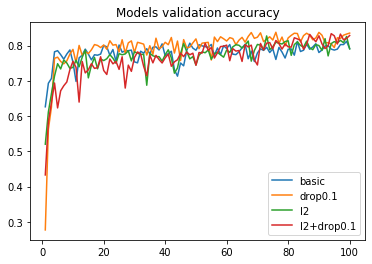

<Figure size 432x288 with 0 Axes>

In [217]:
plt.plot(range(1,101),history.history['val_acc'],label='basic')
plt.plot(range(1,101),history1.history['val_acc'],label='drop0.1')
#plt.plot(range(1,101),history2.history['val_acc'],label='drop0.3')
#plt.plot(range(1,101),history3.history['val_acc'],label='drop3x0.1')
#lt.plot(range(1,101),history4.history['val_acc'],label='l1')
plt.plot(range(1,101),history5.history['val_acc'],label='l2')
plt.plot(range(1,101),history6.history['val_acc'],label='l2+drop0.1')
plt.title('Models validation accuracy')
plt.legend(loc = 'best')
plt.figure()

# Segment

In [0]:
def segment(image):
    # Convert the image into HSV
    hsv_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    # Set the red range
    lower_red=np.array([156, 43, 46])
    upper_red=np.array([180, 255, 255])
    # Apply the orange mask 
    mask = cv2.inRange(hsv_image, lower_red, upper_red)
    result = cv2.bitwise_and(image,image,mask=mask)
    # Clean up the segmentation using a blur
    blur = cv2.GaussianBlur(result, (7, 7), 0)
    return blur

In [0]:
train_x_seg = [segment(image) for image in train_x]

In [0]:
test_x_seg = [segment(image) for image in test_x]

In [0]:
train_x_seg = np.array(train_x_seg)
test_x_seg = np.array(test_x_seg)

In [0]:
def segment_noblur(image):
    # Convert the image into HSV
    hsv_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    # Set the red range
    lower_red=np.array([156, 43, 46])
    upper_red=np.array([180, 255, 255])
    # Apply the orange mask 
    mask = cv2.inRange(hsv_image, lower_red, upper_red)
    result = cv2.bitwise_and(image,image,mask=mask)
    # Clean up the segmentation using a blur
    #blur = cv2.GaussianBlur(result, (7, 7), 0)
    return result

In [0]:
train_x_seg_noblur = [segment_noblur(image) for image in train_x]
test_x_seg_noblur = [segment(image) for image in test_x]
train_x_seg_noblur = np.array(train_x_seg_noblur)
test_x_seg_noblur = np.array(test_x_seg_noblur)

In [73]:
history_seg = model.fit(train_x_seg, trainHot_y, epochs = 100, validation_data=(test_x_seg, testHot_y), shuffle=True)

Train on 9961 samples, validate on 2487 samples
Epoch 1/100
9961/9961 [==============================] - 2s 217us/sample - loss: 1.1515 - acc: 0.4782 - val_loss: 0.9822 - val_acc: 0.5428
Epoch 2/100
9961/9961 [==============================] - 2s 176us/sample - loss: 0.9479 - acc: 0.5730 - val_loss: 0.9725 - val_acc: 0.5786
Epoch 3/100
9961/9961 [==============================] - 2s 177us/sample - loss: 0.7706 - acc: 0.6612 - val_loss: 0.8556 - val_acc: 0.6727
Epoch 4/100
9961/9961 [==============================] - 2s 177us/sample - loss: 0.6242 - acc: 0.7212 - val_loss: 1.1091 - val_acc: 0.6305
Epoch 5/100
9961/9961 [==============================] - 2s 176us/sample - loss: 0.5795 - acc: 0.7373 - val_loss: 0.8559 - val_acc: 0.6807
Epoch 6/100
9961/9961 [==============================] - 2s 173us/sample - loss: 0.5538 - acc: 0.7433 - val_loss: 0.7568 - val_acc: 0.7097
Epoch 7/100
9961/9961 [==============================] - 2s 173us/sample - loss: 0.4934 - acc: 0.7717 - val_loss: 0.76

In [0]:
history_seg_noblur = model.fit(train_x_seg_noblur, trainHot_y, epochs = 100, validation_data=(test_x_seg, testHot_y), shuffle=True)

In [231]:
history_seg1 = model1.fit(train_x_seg, trainHot_y, epochs = 100, validation_data=(test_x_seg, testHot_y), shuffle=True)

Train on 9961 samples, validate on 2487 samples
Epoch 1/100
9961/9961 [==============================] - 2s 233us/sample - loss: 1.9880 - acc: 0.4858 - val_loss: 0.9323 - val_acc: 0.5633
Epoch 2/100
9961/9961 [==============================] - 2s 230us/sample - loss: 0.8749 - acc: 0.5897 - val_loss: 0.9396 - val_acc: 0.5545
Epoch 3/100
9961/9961 [==============================] - 2s 229us/sample - loss: 0.7385 - acc: 0.6330 - val_loss: 0.6863 - val_acc: 0.6156
Epoch 4/100
9961/9961 [==============================] - 2s 228us/sample - loss: 0.6560 - acc: 0.6597 - val_loss: 0.6798 - val_acc: 0.6317
Epoch 5/100
9961/9961 [==============================] - 2s 230us/sample - loss: 0.6067 - acc: 0.6861 - val_loss: 0.6217 - val_acc: 0.6558
Epoch 6/100
9961/9961 [==============================] - 2s 230us/sample - loss: 0.5632 - acc: 0.7004 - val_loss: 0.6109 - val_acc: 0.6739
Epoch 7/100
9961/9961 [==============================] - 2s 241us/sample - loss: 0.5416 - acc: 0.7193 - val_loss: 0.69

In [234]:
history_seg2 = model2.fit(train_x_seg, trainHot_y, epochs = 100, validation_data=(test_x_seg, testHot_y), shuffle=True)

Train on 9961 samples, validate on 2487 samples
Epoch 1/100
9961/9961 [==============================] - 2s 238us/sample - loss: 1.7746 - acc: 0.3909 - val_loss: 1.0826 - val_acc: 0.5428
Epoch 2/100
9961/9961 [==============================] - 2s 234us/sample - loss: 1.0331 - acc: 0.5121 - val_loss: 0.8935 - val_acc: 0.6015
Epoch 3/100
9961/9961 [==============================] - 2s 236us/sample - loss: 0.8378 - acc: 0.6111 - val_loss: 0.6612 - val_acc: 0.7041
Epoch 4/100
9961/9961 [==============================] - 2s 236us/sample - loss: 0.6948 - acc: 0.6697 - val_loss: 0.6079 - val_acc: 0.7419
Epoch 5/100
9961/9961 [==============================] - 2s 239us/sample - loss: 0.6095 - acc: 0.7094 - val_loss: 0.6290 - val_acc: 0.7173
Epoch 6/100
9961/9961 [==============================] - 2s 235us/sample - loss: 0.5480 - acc: 0.7362 - val_loss: 0.5793 - val_acc: 0.7443
Epoch 7/100
9961/9961 [==============================] - 2s 235us/sample - loss: 0.5169 - acc: 0.7571 - val_loss: 0.51

In [235]:
history_seg3 = model3.fit(train_x_seg, trainHot_y, epochs = 100, validation_data=(test_x_seg, testHot_y), shuffle=True)

Train on 9961 samples, validate on 2487 samples
Epoch 1/100
9961/9961 [==============================] - 2s 247us/sample - loss: 1.7798 - acc: 0.4651 - val_loss: 1.1911 - val_acc: 0.4226
Epoch 2/100
9961/9961 [==============================] - 2s 244us/sample - loss: 0.9361 - acc: 0.5746 - val_loss: 1.0723 - val_acc: 0.4950
Epoch 3/100
9961/9961 [==============================] - 2s 244us/sample - loss: 0.7320 - acc: 0.6502 - val_loss: 0.9464 - val_acc: 0.5923
Epoch 4/100
9961/9961 [==============================] - 2s 245us/sample - loss: 0.6434 - acc: 0.6848 - val_loss: 0.6805 - val_acc: 0.6691
Epoch 5/100
9961/9961 [==============================] - 2s 249us/sample - loss: 0.5642 - acc: 0.7165 - val_loss: 0.5842 - val_acc: 0.7025
Epoch 6/100
9961/9961 [==============================] - 2s 246us/sample - loss: 0.5339 - acc: 0.7303 - val_loss: 0.7302 - val_acc: 0.6614
Epoch 7/100
9961/9961 [==============================] - 2s 244us/sample - loss: 0.5084 - acc: 0.7517 - val_loss: 1.11

In [241]:
history_seg4 = model4.fit(train_x_seg, trainHot_y, epochs = 100, validation_data=(test_x_seg, testHot_y), shuffle=True)

Train on 9961 samples, validate on 2487 samples
Epoch 1/100
9961/9961 [==============================] - 2s 228us/sample - loss: 1.4209 - acc: 0.2484 - val_loss: 1.4185 - val_acc: 0.2505
Epoch 2/100
9961/9961 [==============================] - 2s 225us/sample - loss: 1.4086 - acc: 0.2421 - val_loss: 1.4016 - val_acc: 0.2509
Epoch 3/100
9961/9961 [==============================] - 2s 226us/sample - loss: 1.3981 - acc: 0.2464 - val_loss: 1.3956 - val_acc: 0.2509
Epoch 4/100
9961/9961 [==============================] - 2s 230us/sample - loss: 1.3835 - acc: 0.2846 - val_loss: 1.1214 - val_acc: 0.5392
Epoch 5/100
9961/9961 [==============================] - 2s 227us/sample - loss: 1.0799 - acc: 0.4928 - val_loss: 1.0534 - val_acc: 0.5991
Epoch 6/100
9961/9961 [==============================] - 2s 227us/sample - loss: 0.8055 - acc: 0.6522 - val_loss: 0.7332 - val_acc: 0.7479
Epoch 7/100
9961/9961 [==============================] - 2s 226us/sample - loss: 0.6254 - acc: 0.7342 - val_loss: 0.89

In [30]:
history_seg5 = model5.fit(train_x_seg, trainHot_y, epochs = 100, validation_data=(test_x_seg, testHot_y), shuffle=True)

Train on 9961 samples, validate on 2487 samples
Epoch 1/100
9961/9961 [==============================] - 2s 208us/sample - loss: 1.1160 - acc: 0.4993 - val_loss: 0.9943 - val_acc: 0.5408
Epoch 2/100
9961/9961 [==============================] - 2s 191us/sample - loss: 0.8116 - acc: 0.6401 - val_loss: 0.7488 - val_acc: 0.6727
Epoch 3/100
9961/9961 [==============================] - 2s 186us/sample - loss: 0.6448 - acc: 0.7102 - val_loss: 0.7229 - val_acc: 0.7021
Epoch 4/100
9961/9961 [==============================] - 2s 188us/sample - loss: 0.5625 - acc: 0.7528 - val_loss: 0.6176 - val_acc: 0.7230
Epoch 5/100
9961/9961 [==============================] - 2s 189us/sample - loss: 0.5041 - acc: 0.7805 - val_loss: 0.8594 - val_acc: 0.6932
Epoch 6/100
9961/9961 [==============================] - 2s 189us/sample - loss: 0.5216 - acc: 0.7815 - val_loss: 0.8386 - val_acc: 0.6807
Epoch 7/100
9961/9961 [==============================] - 2s 186us/sample - loss: 0.4456 - acc: 0.8183 - val_loss: 0.90

In [59]:
history_seg6 = model6.fit(train_x_seg, trainHot_y, epochs = 100, validation_data=(test_x_seg, testHot_y), shuffle=True)

Train on 9961 samples, validate on 2487 samples
Epoch 1/100
9961/9961 [==============================] - 2s 178us/sample - loss: 0.0946 - acc: 0.9843 - val_loss: 1.6732 - val_acc: 0.7234
Epoch 2/100
9961/9961 [==============================] - 2s 178us/sample - loss: 0.1142 - acc: 0.9800 - val_loss: 1.2504 - val_acc: 0.7547
Epoch 3/100
9961/9961 [==============================] - 2s 174us/sample - loss: 0.1011 - acc: 0.9835 - val_loss: 0.9999 - val_acc: 0.7825
Epoch 4/100
9961/9961 [==============================] - 2s 180us/sample - loss: 0.1258 - acc: 0.9751 - val_loss: 1.0768 - val_acc: 0.7801
Epoch 5/100
9961/9961 [==============================] - 2s 176us/sample - loss: 0.0938 - acc: 0.9856 - val_loss: 1.1820 - val_acc: 0.7636
Epoch 6/100
9961/9961 [==============================] - 2s 175us/sample - loss: 0.1074 - acc: 0.9813 - val_loss: 1.3936 - val_acc: 0.7350
Epoch 7/100
9961/9961 [==============================] - 2s 176us/sample - loss: 0.0941 - acc: 0.9850 - val_loss: 1.25

<Figure size 432x288 with 0 Axes>

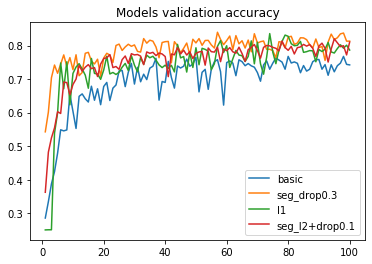

<Figure size 432x288 with 0 Axes>

In [249]:
plt.plot(range(1,101),history_seg.history['val_acc'],label='basic')
#plt.plot(range(1,101),history_seg1.history['val_acc'],label='drop0.1')
plt.plot(range(1,101),history_seg2.history['val_acc'],label='seg_drop0.3')
#plt.plot(range(1,101),history_seg3.history['val_acc'],label='drop3x0.1')
plt.plot(range(1,101),history_seg4.history['val_acc'],label='l1')
#plt.plot(range(1,101),history_seg5.history['val_acc'],label='l2')
plt.plot(range(1,101),history_seg6.history['val_acc'],label='seg_l2+drop0.1')
plt.title('Models validation accuracy')
plt.legend(loc = 'best')
plt.figure()

<Figure size 432x288 with 0 Axes>

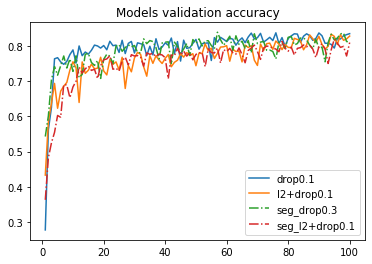

<Figure size 432x288 with 0 Axes>

In [255]:
plt.plot(range(1,101),history1.history['val_acc'],label='drop0.1')
#plt.plot(range(1,101),history5.history['val_acc'],label='l2')
plt.plot(range(1,101),history6.history['val_acc'],label='l2+drop0.1')
plt.plot(range(1,101),history_seg2.history['val_acc'],label='seg_drop0.3',linestyle='-.')
#plt.plot(range(1,101),history_seg4.history['val_acc'],label='seg_l1',linestyle='-.')
plt.plot(range(1,101),history_seg6.history['val_acc'],label='seg_l2+drop0.1',linestyle='-.')
plt.title('Models validation accuracy')
plt.legend(loc = 'best')
plt.figure()

In [220]:
train_x_seg[0].shape

(60, 80, 3)

In [222]:
np.array(train_x).shape

(9961, 60, 80, 3)

In [74]:
model.evaluate(test_x_seg,testHot_y)

2487/2487 [==============================] - 0s 96us/sample - loss: 2.3789 - acc: 0.7222


[2.3789452699506755, 0.7221552]

In [259]:
model1.evaluate(test_x_seg,testHot_y)

2487/2487 [==============================] - 0s 126us/sample - loss: 1.0281 - acc: 0.7784


[1.0281188167125335, 0.7784479]

In [260]:
model2.evaluate(test_x_seg,testHot_y)

2487/2487 [==============================] - 0s 131us/sample - loss: 0.6961 - acc: 0.8130


[0.6961397845438481, 0.81302774]

In [261]:
model3.evaluate(test_x_seg,testHot_y)

2487/2487 [==============================] - 0s 137us/sample - loss: 0.7973 - acc: 0.7909


[0.7973405691945965, 0.79091275]

In [262]:
model4.evaluate(test_x_seg,testHot_y)

2487/2487 [==============================] - 0s 134us/sample - loss: 0.8059 - acc: 0.7865


[0.8059320550967662, 0.7864897]

In [32]:
model5.evaluate(test_x_seg,testHot_y)

2487/2487 [==============================] - 0s 99us/sample - loss: 1.4889 - acc: 0.7226


[1.4888920598495998, 0.7225573]

In [60]:
model6.evaluate(test_x_seg,testHot_y)

2487/2487 [==============================] - 0s 105us/sample - loss: 1.2543 - acc: 0.7587


[1.2543031952685029, 0.7587455]

# VGG16

In [34]:
import tensorflow
vgg_model = tensorflow.keras.applications.vgg16.VGG16()

553467904/553467096 [==============================] - 16s 0us/step


In [0]:
from keras.applications import VGG16
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout

In [0]:
conv_base = VGG16(weights="imagenet",include_top=False,input_shape=(60,80,3))
conv_base.trainable=False

In [0]:
model7 = Sequential()
model7.add(conv_base)
#model1.add(Dropout(0.25))
model7.add(Flatten())
model7.add(Dense(16, activation="relu"))
model7.add(Dense(5, activation="softmax"))

In [0]:
model7.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy']
              #callbacks = [EarlyStopping(monitor='val_acc', patience=5)]
              )

In [57]:
history7 = model7.fit(train_x, trainHot_y, epochs = 100, validation_data=(test_x, testHot_y), shuffle=True)

Train on 9961 samples, validate on 2487 samples
Epoch 1/100
9961/9961 [==============================] - 5s 535us/step - loss: 7.3819 - acc: 0.2863 - val_loss: 3.7306 - val_acc: 0.2686
Epoch 2/100
9961/9961 [==============================] - 5s 536us/step - loss: 2.3338 - acc: 0.2778 - val_loss: 2.1978 - val_acc: 0.2626
Epoch 3/100
9961/9961 [==============================] - 5s 538us/step - loss: 1.7169 - acc: 0.2872 - val_loss: 1.8444 - val_acc: 0.2710
Epoch 4/100
9961/9961 [==============================] - 5s 541us/step - loss: 1.5591 - acc: 0.3021 - val_loss: 1.7245 - val_acc: 0.2786
Epoch 5/100
9961/9961 [==============================] - 5s 542us/step - loss: 1.4638 - acc: 0.3225 - val_loss: 1.6475 - val_acc: 0.2778
Epoch 6/100
9961/9961 [==============================] - 5s 528us/step - loss: 1.4203 - acc: 0.3255 - val_loss: 1.6205 - val_acc: 0.2738
Epoch 7/100
9961/9961 [==============================] - 5s 545us/step - loss: 1.3702 - acc: 0.3405 - val_loss: 1.5668 - val_acc: 

In [63]:
model7.evaluate(test_x,testHot_y)

2487/2487 [==============================] - 1s 398us/step


[1.9224024227358607, 0.3827905107033411]

In [64]:
history_seg7 = model7.fit(train_x_seg, trainHot_y, epochs = 100, validation_data=(test_x_seg, testHot_y), shuffle=True)

Train on 9961 samples, validate on 2487 samples
Epoch 1/100
9961/9961 [==============================] - 5s 550us/step - loss: 0.8831 - acc: 0.6192 - val_loss: 1.3761 - val_acc: 0.5388
Epoch 2/100
9961/9961 [==============================] - 5s 538us/step - loss: 0.7898 - acc: 0.6583 - val_loss: 1.4910 - val_acc: 0.5259
Epoch 3/100
9961/9961 [==============================] - 5s 541us/step - loss: 0.7345 - acc: 0.6860 - val_loss: 1.3871 - val_acc: 0.5396
Epoch 4/100
9961/9961 [==============================] - 5s 531us/step - loss: 0.6971 - acc: 0.7071 - val_loss: 1.3970 - val_acc: 0.5408
Epoch 5/100
9961/9961 [==============================] - 5s 543us/step - loss: 0.6690 - acc: 0.7183 - val_loss: 1.5635 - val_acc: 0.5300
Epoch 6/100
9961/9961 [==============================] - 5s 547us/step - loss: 0.6527 - acc: 0.7241 - val_loss: 1.5368 - val_acc: 0.5332
Epoch 7/100
9961/9961 [==============================] - 5s 551us/step - loss: 0.6349 - acc: 0.7317 - val_loss: 1.5289 - val_acc: 

In [0]:
model7.save('/content/gdrive/Shared drives/590 project/model7.h5')

In [65]:
model7.evaluate(test_x_seg,testHot_y)

2487/2487 [==============================] - 1s 399us/step


[2.7028084498214877, 0.5090470446800198]